In [25]:
import torch 
import numpy as np
from matplotlib import pyplot as plt
import math
import botorch
import gpytorch
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

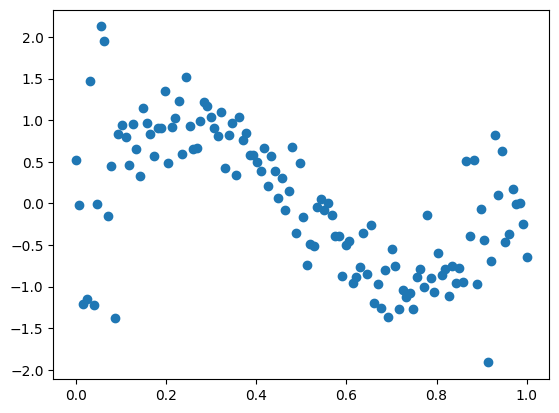

In [82]:
train_x = torch.linspace(0, 1, 128).double()
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.09)
for i in range(12):
    train_y[i]+=torch.randn(1).squeeze() - 0.5
    
for i in range(7):
    train_y[i*2+110]+=torch.randn(1).squeeze() - 0.5
#train_y = train_x**3 - 0.25 + torch.randn(train_x.size()) * math.sqrt(0.04)

plt.scatter(train_x, train_y)

In [83]:
model = SingleTaskGP(train_x.unsqueeze(-1), train_y.unsqueeze(-1), input_transform=Normalize(d=1), outcome_transform=Standardize(m=1))

In [84]:
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)

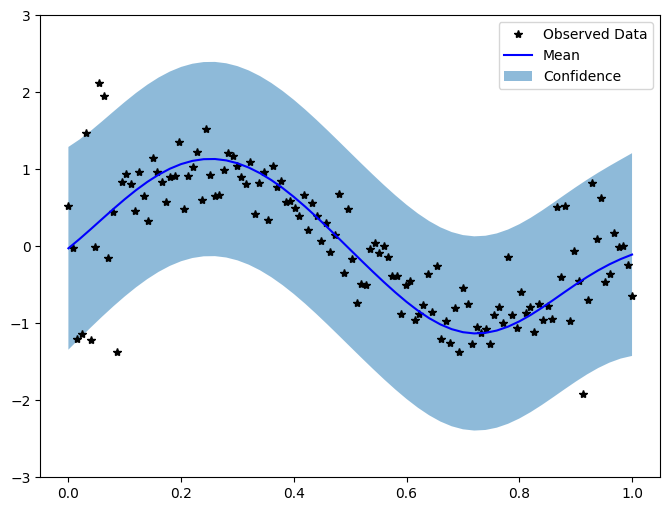

In [85]:
# Get into evaluation (predictive posterior) mode
# model.eval()
# likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = model.likelihood(model(test_x))
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])